# EXP: ResNet-34: CIFAR-10 + PyTorch + ```albumentations```

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER = PCI_BUS_ID
'''
Specify GPU(s) to be used here. Say you have 6 GPUs and you want to train Model A on 2 of them
and Model B on 4 of them. You can do that as follows-
CUDA_VISIBLE_DEVICES=0,1 python model_A.py
CUDA_VISIBLE_DEVICES=2,3,4,5 python model_B.py
'''
# %env CUDA_VISIBLE_DEVICES = 0, 1, 2, 3
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
# import torchvision.transforms as transforms

from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os, pickle
import albumentations as A
from albumentations.pytorch import ToTensorV2

C:\Users\arjun\anaconda3\envs\torch-cuda\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print(f"torch version: {torch.__version__}")

# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

# Which GPU Is The Current GPU?
# print(f"current GPU: {torch.cuda.current_device()}")

# Get the name of the current GPU-
# print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Is PyTorch using a GPU?
# print(f"Is PyTorch using a GPU? {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

torch version: 1.13.1
Number of GPU(s) available = 1
Current GPU: 0
Current GPU name: NVIDIA GeForce RTX 3080 Laptop GPU


In [4]:
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

Available device is cuda


In [ ]:
# print(torch.cuda.memory_summary())

In [5]:
# Specify hyper-parameters
batch_size = 256
num_classes = 10
num_epochs = 80

In [6]:
# Define transformations using albumentations-
transform_train = A.Compose(
    [
        # A.Resize(width = 32, height = 32),
        # A.RandomCrop(width = 20, height = 20),
        A.Rotate(limit = 40, p = 0.9, border_mode = cv2.BORDER_CONSTANT),
        A.HorizontalFlip(p = 0.5),
        A.VerticalFlip(p = 0.1),
        A.RGBShift(r_shift_limit = 25, g_shift_limit = 25, b_shift_limit = 25, p = 0.9),
        A.OneOf([
            A.Blur(blur_limit = 3, p = 0.5),
            A.ColorJitter(p = 0.5),
        ], p = 1.0),
        A.Normalize(
            # mean = [0.4914, 0.4822, 0.4465],
            # std = [0.247, 0.243, 0.261],
            mean = [0, 0, 0],
            std = [1, 1, 1],
            max_pixel_value = 255,
        ),
        # This is not dividing by 255, which it does in PyTorch-
        ToTensorV2(),
    ]
)

transform_val = A.Compose(
    [
        A.Normalize(
            mean = [0, 0, 0],
            std = [1, 1, 1],
            max_pixel_value = 255
        ),
        ToTensorV2()
    ]
)


In [7]:
class Cifar10Dataset(torchvision.datasets.CIFAR10):
    def __init__(
        self, root = "~/data/cifar10",
        train = True, download = True,
        transform = None
    ):
        super().__init__(
            root = root, train = train,
            download = download, transform = transform
        )

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image = image)
            image = transformed["image"]

        return image, label


In [8]:
# Define train and validate sets-
train_dataset = Cifar10Dataset(
    root = 'C:/Users/arjun/Downloads/data/', train = True,
    download = True, transform = transform_train
)

val_dataset = Cifar10Dataset(
    root = 'C:/Users/arjun/Downloads/data/', train = False,
    download = True, transform = transform_val
)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
# Define train and validate loaders-
train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset, batch_size = batch_size,
    shuffle = True
    )

val_loader = torch.utils.data.DataLoader(
    dataset = val_dataset, batch_size = batch_size,
    shuffle = True
    )

In [10]:
print(f"len(train_dataset) = {len(train_dataset)} & len(val_dataset) = {len(val_dataset)}")
print(f"len(train_loader) = {len(train_loader)} & len(val_loader) = {len(val_loader)}")

# Sanity check-
len(train_dataset) / batch_size, len(val_dataset) / batch_size

len(train_dataset) = 50000 & len(val_dataset) = 10000
len(train_loader) = 196 & len(val_loader) = 40


(195.3125, 39.0625)

#### ResNet-34 CNN architecture

In [11]:
class ResNet_Block(nn.Module):
    '''
    Residual block for a ResNet CNN model
    '''
    def __init__(
        self, num_inp_channels,
        num_channels, stride = 1,
        dropout = 0.2, use_1x1_conv = False
    ):
        super(ResNet_Block, self).__init__()
        
        self.num_inp_channels = num_inp_channels
        self.num_channels = num_channels
        self.stride = stride
        self.dropout = dropout
        self.use_1x1_conv = use_1x1_conv
    
        
        self.conv1 = nn.Conv2d(
            in_channels = self.num_inp_channels, out_channels = self.num_channels,
            kernel_size = 3, padding = 1,
            stride = self.stride, bias = False
        )
        self.bn1 = nn.BatchNorm2d(num_features = self.num_channels)
        
        self.conv2 = nn.Conv2d(
            in_channels = self.num_channels, out_channels = self.num_channels,
            kernel_size = 3, padding = 1,
            stride = 1, bias = False
        )
        self.bn2 = nn.BatchNorm2d(num_features = self.num_channels)
        self.dropout = nn.Dropout(p = self.dropout)
        
        if self.use_1x1_conv:
            self.conv3 = nn.Conv2d(
            in_channels = self.num_inp_channels, out_channels = num_channels,
            kernel_size = 1, padding = 0,
            stride = self.stride, bias = False
            )
            self.bn3 = nn.BatchNorm2d(num_features = self.num_channels)
        
        self.initialize_weights()

            
    def initialize_weights(self):
        for m in self.modules():
            # print(m)
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)

                '''
                # Do not initialize bias (due to batchnorm)-
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                '''
            
            elif isinstance(m, nn.BatchNorm2d):
                # Standard initialization for batch normalization-
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    
    def forward(self, x):
        y = F.leaky_relu(self.bn1(self.conv1(x)))
        y = self.dropout(F.leaky_relu(self.bn2(self.conv2(y))))
        
        if self.use_1x1_conv:
            x = self.bn3(self.conv3(x))
            
        y += x
        return F.leaky_relu(self.dropout(y))
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        y = (self.bn1(self.conv1(x)))
        print(f"First conv layer output shape: {y.shape}")
        y = self.bn2(self.conv2(y))
        print(f"Second conv layer output shape: {y.shape}")
        
        if self.use_1x1_conv:
            x = self.bn3(self.conv3(x))
            print(f"Downsample with S = 2; identity connection output shape: {x.shape}")
            
        y += x
        print(f"Residual block output shape: {y.shape}")
        return None
    

In [12]:
class ResNet34(nn.Module):
    def __init__(self):
        super(ResNet34, self).__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels = 3, out_channels = 64,
            kernel_size = 3, padding = 1,
            stride = 1, bias = False
        )
        self.bn1 = nn.BatchNorm2d(num_features = 64)
        
        self.resblock1 = ResNet_Block(
            num_inp_channels = 64, num_channels = 64,
            stride = 1, dropout = 0.2,
            use_1x1_conv = False
        )
        
        self.resblock2 = ResNet_Block(
            num_inp_channels = 64, num_channels = 64,
            stride = 1, dropout = 0.2,
            use_1x1_conv = False
        )

        self.resblock3 = ResNet_Block(
            num_inp_channels = 64, num_channels = 64,
            stride = 1, dropout = 0.2,
            use_1x1_conv = False
        )
        
        # Downsample-
        self.resblock4 = ResNet_Block(
            num_inp_channels = 64, num_channels = 128,
            stride = 2, dropout = 0.2,
            use_1x1_conv = True
        )
        
        self.resblock5 = ResNet_Block(
            num_inp_channels = 128, num_channels = 128,
            stride = 1, dropout = 0.2,
            use_1x1_conv = False
        )

        self.resblock6 = ResNet_Block(
            num_inp_channels = 128, num_channels = 128,
            stride = 1, dropout = 0.2,
            use_1x1_conv = False
        )

        self.resblock7 = ResNet_Block(
            num_inp_channels = 128, num_channels = 128,
            stride = 1, dropout = 0.2,
            use_1x1_conv = False
        )

        # Downsample-
        self.resblock8 = ResNet_Block(
            num_inp_channels = 128, num_channels = 256,
            stride = 2, dropout = 0.2,
            use_1x1_conv = True
        )

        self.resblock9 = ResNet_Block(
            num_inp_channels = 256, num_channels = 256,
            stride = 1, dropout = 0.2,
            use_1x1_conv = False
        )

        self.resblock10 = ResNet_Block(
            num_inp_channels = 256, num_channels = 256,
            stride = 1, dropout = 0.2,
            use_1x1_conv = False
        )

        self.resblock11 = ResNet_Block(
            num_inp_channels = 256, num_channels = 256,
            stride = 1, dropout = 0.2,
            use_1x1_conv = False
        )

        self.resblock12 = ResNet_Block(
            num_inp_channels = 256, num_channels = 256,
            stride = 1, dropout = 0.2,
            use_1x1_conv = False
        )

        self.resblock13 = ResNet_Block(
            num_inp_channels = 256, num_channels = 256,
            stride = 1, dropout = 0.2,
            use_1x1_conv = False
        )

        # Downsample-
        self.resblock14 = ResNet_Block(
            num_inp_channels = 256, num_channels = 512,
            stride = 2, dropout = 0.2,
            use_1x1_conv = True
        )

        self.resblock15 = ResNet_Block(
            num_inp_channels = 512, num_channels = 512,
            stride = 1, dropout = 0.2,
            use_1x1_conv = False
        )

        self.resblock16 = ResNet_Block(
            num_inp_channels = 512, num_channels = 512,
            stride = 1, dropout = 0.2,
            use_1x1_conv = False
        )
        
        self.avg_pool = nn.AvgPool2d(kernel_size = 3, stride = 2)
        self.op_layer = nn.Linear(
            in_features = 512, out_features = 10,
            bias = True
        )
        
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.resblock4(x)
        x = self.resblock5(x)
        x = self.resblock6(x)
        x = self.resblock7(x)
        x = self.resblock8(x)
        x = self.resblock9(x)
        x = self.resblock10(x)
        x = self.resblock11(x)
        x = self.resblock12(x)
        x = self.resblock13(x)
        x = self.resblock14(x)
        x = self.resblock15(x)
        x = self.resblock16(x)
        x = self.avg_pool(x).squeeze()
        x = self.op_layer(x)
        return x


In [13]:
# Initialize ResNet-34 CNN architecture-
model = ResNet34().to(device)

In [14]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in model.parameters():
    # print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()

print(f"Total number of parameters in ResNet-34 CNN = {tot_params}")

Total number of parameters in ResNet-34 CNN = 21282122


In [15]:
# Save random initial weights-
torch.save(model.state_dict(), 'ResNet34_random_weights.pth')

# Load randomly initialised weights-
# model.load_state_dict(torch.load('ResNet34_random_weights.pth'))

In [16]:
# Define loss function and optimizer-
loss = nn.CrossEntropyLoss()

# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.0, momentum = 0.9, weight_decay = 5e-4)

#### Train model with learning rate scheduler

Training dataset = 50000, batch size = 256, number of training steps/iterations per epoch = 50000 / 256 = 195.3125 = 195

After an initial linear learning rate warmup of 13 epochs or 2539 training steps:

- For the next 32 epochs, or, 6250 steps - until 43rd epoch, use lr = 0.1.

- For the next 25 epochs, or, 4882 steps - until 68th epoch, use lr = 0.01.

- For remaining epochs (13 epochs), use lr = 0.001.

In [17]:
boundaries = [6250, 11132]
values = [0.1, 0.01, 0.001]

In [18]:
def decay_function(step, boundaries = [6250, 11132], values = [0.1, 0.01, 0.001]):
    
    for idx, bound in enumerate(boundaries):
        if step < bound:
            return values[idx]

    return values[-1]
    

In [19]:
class schedule():

    def __init__(self, initial_learning_rate = 0.1, warmup_steps = 1000, decay_func = None):
        self.initial_learning_rate = initial_learning_rate
        self.warmup_steps = warmup_steps
        self.decay_func = decay_func
        self.warmup_step_size = initial_learning_rate/warmup_steps
        self.current_lr = 0

    def get_lr(self, step):
        if step == 0:
            return self.current_lr
        elif step <= self.warmup_steps:
            self.current_lr+=self.warmup_step_size
            return self.current_lr
        elif step > self.warmup_steps:
            if self.decay_func:
                return self.decay_func(step)
        else:
            return self.current_lr
            

In [20]:
# Initial linear LR warmup: 195.3125 x 13 = 2549 steps in 13 epochs.
custom_lr_scheduler = schedule(
    initial_learning_rate = 0.1, warmup_steps = 2539,
    decay_func = decay_function
)

In [21]:
step = 0

In [22]:
def train_model_progress(model, train_loader, train_dataset):
    '''
    Function to perform one epoch of training by using 'train_loader'.
    Returns loss and number of correct predictions for this epoch.
    '''
    running_loss = 0.0
    running_corrects = 0.0
    
    model.train()
    
    with tqdm(train_loader, unit = 'batch') as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Training: ")
            
            images = images.to(device)
            labels = labels.to(device)
            
            # Get model predictions-
            outputs = model(images)
            
            # Compute loss-
            J = loss(outputs, labels)
            
            # Empty accumulated gradients-
            optimizer.zero_grad()
            
            # Perform backprop-
            J.backward()
            
            # Update parameters-
            optimizer.step()
            
            global step
            optimizer.param_groups[0]['lr'] = custom_lr_scheduler.get_lr(step)

            step += 1
            
            # Compute model's performance statistics-
            running_loss += J.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            running_corrects += torch.sum(predicted == labels.data)
            
            tepoch.set_postfix(
                loss = running_loss / len(train_dataset),
                accuracy = (running_corrects.double().cpu().numpy() / len(train_dataset)) * 100
            )
            
    
    train_loss = running_loss / len(train_dataset)
    train_acc = (running_corrects.double() / len(train_dataset)) * 100
    

    # return running_loss, running_corrects
    return train_loss, train_acc.cpu().numpy()


In [23]:
def test_model_progress(model, test_loader, test_dataset):
    total = 0.0
    correct = 0.0
    running_loss_val = 0.0

    with torch.no_grad():
        with tqdm(test_loader, unit = 'batch') as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Validation: ")
                
                images = images.to(device)
                labels = labels.to(device)
                
                # Set model to evaluation mode-
                model.eval()
            
                # Predict using trained model-
                outputs = model(images)
                _, y_pred = torch.max(outputs, 1)
                
                # Compute validation loss-
                J_val = loss(outputs, labels)
                
                running_loss_val += J_val.item() * labels.size(0)
    
                # Total number of labels-
                total += labels.size(0)

                # Total number of correct predictions-
                correct += (y_pred == labels).sum()
                
                tepoch.set_postfix(
                    val_loss = running_loss_val / len(test_dataset),
                    val_acc = 100 * (correct.cpu().numpy() / total)
                )
            
        
    # return (running_loss_val, correct, total)
    val_loss = running_loss_val / len(test_dataset)
    val_acc = (correct / total) * 100

    return val_loss, val_acc.cpu().numpy()
    

In [24]:
# Python3 dict to contain training metrics-
training_history_lr_scheduler = {}

# Initialize parameters saving 'best' models-
best_val_acc = 80

In [25]:
for epoch in range(num_epochs):

    # Train and validate model for 1 epoch-
    train_loss, train_acc = train_model_progress(
        model = model, train_loader = train_loader,
        train_dataset = train_dataset
    )
    val_loss, val_acc = test_model_progress(
        model = model, test_loader = val_loader,
        test_dataset = val_dataset
    )
    
    print(f"\nepoch: {epoch + 1} training loss = {train_loss:.4f}, "
          f"training accuracy = {train_acc:.2f}%, val_loss = {val_loss:.4f}"
          f", val_accuracy = {val_acc:.2f}% & "
          f"LR = {optimizer.param_groups[0]['lr']:.5f}\n")
    
    training_history_lr_scheduler[epoch + 1] = {
        'loss': train_loss, 'acc': train_acc,
        'val_loss': val_loss, 'val_acc': val_acc,
        'lr': optimizer.param_groups[0]['lr']
    }

    
    # Save best weights achieved until now-
    if (val_acc > best_val_acc):
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_acc = val_acc

        print(f"Saving model with highest val_acc = {val_acc:.2f}%\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "ResNet34_best_model.pth")
        

Validation: : 100%|██████████████████████████████████████| 40/40 [00:03<00:00, 10.25batch/s, val_acc=10, val_loss=3.31]



epoch: 1 training loss = 2.3111, training accuracy = 14.60%, val_loss = 3.3113, val_accuracy = 10.00% & LR = 0.00768



Validation: : 100%|████████████████████████████████████| 40/40 [00:03<00:00, 11.40batch/s, val_acc=9.94, val_loss=3.92]



epoch: 2 training loss = 2.1794, training accuracy = 18.83%, val_loss = 3.9165, val_accuracy = 9.94% & LR = 0.01540



Validation: : 100%|██████████████████████████████████████| 40/40 [00:02<00:00, 13.53batch/s, val_acc=10, val_loss=4.97]



epoch: 3 training loss = 2.0701, training accuracy = 21.85%, val_loss = 4.9727, val_accuracy = 10.00% & LR = 0.02312



Validation: : 100%|████████████████████████████████████| 40/40 [00:02<00:00, 13.47batch/s, val_acc=12.7, val_loss=3.83]



epoch: 4 training loss = 1.9451, training accuracy = 26.61%, val_loss = 3.8259, val_accuracy = 12.69% & LR = 0.03084



Validation: : 100%|██████████████████████████████████████| 40/40 [00:03<00:00, 12.51batch/s, val_acc=20, val_loss=2.56]



epoch: 5 training loss = 1.8517, training accuracy = 30.57%, val_loss = 2.5570, val_accuracy = 20.03% & LR = 0.03856



Validation: : 100%|████████████████████████████████████| 40/40 [00:02<00:00, 13.34batch/s, val_acc=28.8, val_loss=2.45]



epoch: 6 training loss = 1.7573, training accuracy = 34.47%, val_loss = 2.4499, val_accuracy = 28.81% & LR = 0.04628



Validation: : 100%|█████████████████████████████████████| 40/40 [00:03<00:00, 12.77batch/s, val_acc=25.8, val_loss=2.6]



epoch: 7 training loss = 1.6678, training accuracy = 38.29%, val_loss = 2.5965, val_accuracy = 25.79% & LR = 0.05400



Validation: : 100%|████████████████████████████████████| 40/40 [00:03<00:00, 13.03batch/s, val_acc=38.4, val_loss=1.99]



epoch: 8 training loss = 1.5809, training accuracy = 42.07%, val_loss = 1.9854, val_accuracy = 38.41% & LR = 0.06172



Validation: : 100%|█████████████████████████████████████| 40/40 [00:03<00:00, 12.52batch/s, val_acc=48.2, val_loss=1.5]



epoch: 9 training loss = 1.5163, training accuracy = 44.81%, val_loss = 1.5047, val_accuracy = 48.23% & LR = 0.06944



Validation: : 100%|████████████████████████████████████| 40/40 [00:03<00:00, 10.75batch/s, val_acc=50.1, val_loss=1.45]



epoch: 10 training loss = 1.4496, training accuracy = 47.81%, val_loss = 1.4487, val_accuracy = 50.09% & LR = 0.07716



Validation: : 100%|████████████████████████████████████| 40/40 [00:02<00:00, 13.37batch/s, val_acc=46.2, val_loss=1.69]



epoch: 11 training loss = 1.3804, training accuracy = 50.30%, val_loss = 1.6888, val_accuracy = 46.25% & LR = 0.08488



Validation: : 100%|██████████████████████████████████████| 40/40 [00:03<00:00, 11.69batch/s, val_acc=54, val_loss=1.35]



epoch: 12 training loss = 1.3146, training accuracy = 53.20%, val_loss = 1.3550, val_accuracy = 54.03% & LR = 0.09260



Validation: : 100%|████████████████████████████████████| 40/40 [00:03<00:00, 12.28batch/s, val_acc=62.1, val_loss=1.07]



epoch: 13 training loss = 1.2638, training accuracy = 54.79%, val_loss = 1.0723, val_accuracy = 62.05% & LR = 0.10000



Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  9.53batch/s, val_acc=63.1, val_loss=1.06]



epoch: 14 training loss = 1.2092, training accuracy = 57.29%, val_loss = 1.0596, val_accuracy = 63.10% & LR = 0.10000



Validation: : 100%|████████████████████████████████████| 40/40 [00:02<00:00, 13.44batch/s, val_acc=60.4, val_loss=1.14]



epoch: 15 training loss = 1.1689, training accuracy = 58.58%, val_loss = 1.1367, val_accuracy = 60.40% & LR = 0.10000



Validation: : 100%|████████████████████████████████████| 40/40 [00:03<00:00, 13.20batch/s, val_acc=61.3, val_loss=1.16]



epoch: 16 training loss = 1.1241, training accuracy = 60.34%, val_loss = 1.1606, val_accuracy = 61.30% & LR = 0.10000



Validation: : 100%|███████████████████████████████████████| 40/40 [00:03<00:00, 12.58batch/s, val_acc=56, val_loss=1.4]



epoch: 17 training loss = 1.0951, training accuracy = 61.59%, val_loss = 1.4013, val_accuracy = 56.00% & LR = 0.10000



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 13.55batch/s, val_acc=68.4, val_loss=0.967]



epoch: 18 training loss = 1.0615, training accuracy = 62.90%, val_loss = 0.9673, val_accuracy = 68.38% & LR = 0.10000



Validation: : 100%|█████████████████████████████████████| 40/40 [00:03<00:00, 12.44batch/s, val_acc=70.2, val_loss=0.9]



epoch: 19 training loss = 1.0404, training accuracy = 63.62%, val_loss = 0.8997, val_accuracy = 70.20% & LR = 0.10000



Validation: : 100%|███████████████████████████████████| 40/40 [00:03<00:00, 12.33batch/s, val_acc=70.7, val_loss=0.859]



epoch: 20 training loss = 1.0129, training accuracy = 64.64%, val_loss = 0.8591, val_accuracy = 70.73% & LR = 0.10000



Validation: : 100%|███████████████████████████████████| 40/40 [00:03<00:00, 11.66batch/s, val_acc=69.4, val_loss=0.875]



epoch: 21 training loss = 0.9924, training accuracy = 65.25%, val_loss = 0.8746, val_accuracy = 69.39% & LR = 0.10000



Validation: : 100%|████████████████████████████████████| 40/40 [00:03<00:00, 12.46batch/s, val_acc=72.7, val_loss=0.82]



epoch: 22 training loss = 0.9620, training accuracy = 66.49%, val_loss = 0.8197, val_accuracy = 72.68% & LR = 0.10000



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 13.43batch/s, val_acc=75.1, val_loss=0.746]



epoch: 23 training loss = 0.9476, training accuracy = 66.84%, val_loss = 0.7460, val_accuracy = 75.07% & LR = 0.10000



Validation: : 100%|███████████████████████████████████| 40/40 [00:03<00:00, 11.36batch/s, val_acc=75.5, val_loss=0.711]



epoch: 24 training loss = 0.9298, training accuracy = 67.46%, val_loss = 0.7113, val_accuracy = 75.46% & LR = 0.10000



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 13.44batch/s, val_acc=72.2, val_loss=0.836]



epoch: 25 training loss = 0.9144, training accuracy = 68.13%, val_loss = 0.8357, val_accuracy = 72.17% & LR = 0.10000



Validation: : 100%|█████████████████████████████████████| 40/40 [00:03<00:00, 11.43batch/s, val_acc=75, val_loss=0.759]



epoch: 26 training loss = 0.9092, training accuracy = 68.29%, val_loss = 0.7587, val_accuracy = 75.04% & LR = 0.10000



Validation: : 100%|█████████████████████████████████████| 40/40 [00:03<00:00, 11.90batch/s, val_acc=78, val_loss=0.654]



epoch: 27 training loss = 0.8949, training accuracy = 68.77%, val_loss = 0.6540, val_accuracy = 78.02% & LR = 0.10000



Validation: : 100%|███████████████████████████████████| 40/40 [00:03<00:00, 10.86batch/s, val_acc=75.4, val_loss=0.759]



epoch: 28 training loss = 0.8782, training accuracy = 69.68%, val_loss = 0.7594, val_accuracy = 75.40% & LR = 0.10000



Validation: : 100%|███████████████████████████████████| 40/40 [00:03<00:00, 11.28batch/s, val_acc=77.5, val_loss=0.679]



epoch: 29 training loss = 0.8775, training accuracy = 69.45%, val_loss = 0.6786, val_accuracy = 77.50% & LR = 0.10000



Validation: : 100%|███████████████████████████████████| 40/40 [00:03<00:00, 12.80batch/s, val_acc=76.4, val_loss=0.709]



epoch: 30 training loss = 0.8632, training accuracy = 70.13%, val_loss = 0.7092, val_accuracy = 76.43% & LR = 0.10000



Validation: : 100%|███████████████████████████████████| 40/40 [00:03<00:00, 10.62batch/s, val_acc=76.6, val_loss=0.687]



epoch: 31 training loss = 0.8652, training accuracy = 69.97%, val_loss = 0.6871, val_accuracy = 76.64% & LR = 0.10000



Validation: : 100%|███████████████████████████████████| 40/40 [00:03<00:00, 10.35batch/s, val_acc=83.2, val_loss=0.496]



epoch: 32 training loss = 0.8479, training accuracy = 70.57%, val_loss = 0.4955, val_accuracy = 83.20% & LR = 0.01000

Saving model with highest val_acc = 83.20%



Validation: : 100%|███████████████████████████████████| 40/40 [00:03<00:00, 11.67batch/s, val_acc=85.2, val_loss=0.447]



epoch: 33 training loss = 0.6788, training accuracy = 76.45%, val_loss = 0.4467, val_accuracy = 85.23% & LR = 0.01000

Saving model with highest val_acc = 85.23%



Validation: : 100%|███████████████████████████████████| 40/40 [00:03<00:00, 12.98batch/s, val_acc=85.4, val_loss=0.432]



epoch: 34 training loss = 0.6415, training accuracy = 77.61%, val_loss = 0.4321, val_accuracy = 85.39% & LR = 0.01000

Saving model with highest val_acc = 85.39%



Validation: : 100%|███████████████████████████████████| 40/40 [00:03<00:00, 12.94batch/s, val_acc=86.5, val_loss=0.412]



epoch: 35 training loss = 0.6182, training accuracy = 78.52%, val_loss = 0.4124, val_accuracy = 86.50% & LR = 0.01000

Saving model with highest val_acc = 86.50%



Validation: : 100%|███████████████████████████████████| 40/40 [00:03<00:00, 12.10batch/s, val_acc=86.4, val_loss=0.408]



epoch: 36 training loss = 0.6089, training accuracy = 78.81%, val_loss = 0.4076, val_accuracy = 86.36% & LR = 0.01000



Validation: : 100%|███████████████████████████████████| 40/40 [00:03<00:00, 11.40batch/s, val_acc=86.6, val_loss=0.401]



epoch: 37 training loss = 0.5948, training accuracy = 79.37%, val_loss = 0.4010, val_accuracy = 86.63% & LR = 0.01000

Saving model with highest val_acc = 86.63%



Validation: : 100%|███████████████████████████████████| 40/40 [00:03<00:00, 10.91batch/s, val_acc=86.7, val_loss=0.392]



epoch: 38 training loss = 0.5876, training accuracy = 79.54%, val_loss = 0.3916, val_accuracy = 86.71% & LR = 0.01000

Saving model with highest val_acc = 86.71%



Validation: : 100%|███████████████████████████████████| 40/40 [00:03<00:00, 12.54batch/s, val_acc=87.1, val_loss=0.387]



epoch: 39 training loss = 0.5782, training accuracy = 79.77%, val_loss = 0.3873, val_accuracy = 87.07% & LR = 0.01000

Saving model with highest val_acc = 87.07%



Validation: : 100%|███████████████████████████████████| 40/40 [00:03<00:00, 13.13batch/s, val_acc=86.3, val_loss=0.403]



epoch: 40 training loss = 0.5696, training accuracy = 80.40%, val_loss = 0.4033, val_accuracy = 86.32% & LR = 0.01000



Validation: : 100%|█████████████████████████████████████| 40/40 [00:03<00:00, 11.77batch/s, val_acc=87, val_loss=0.387]



epoch: 41 training loss = 0.5650, training accuracy = 80.43%, val_loss = 0.3869, val_accuracy = 87.00% & LR = 0.01000



Validation: : 100%|███████████████████████████████████| 40/40 [00:03<00:00, 12.23batch/s, val_acc=87.1, val_loss=0.379]



epoch: 42 training loss = 0.5548, training accuracy = 80.80%, val_loss = 0.3790, val_accuracy = 87.13% & LR = 0.01000

Saving model with highest val_acc = 87.13%



Validation: : 100%|██████████████████████████████████████| 40/40 [00:03<00:00, 12.10batch/s, val_acc=87, val_loss=0.39]



epoch: 43 training loss = 0.5425, training accuracy = 81.26%, val_loss = 0.3900, val_accuracy = 87.04% & LR = 0.01000



Validation: : 100%|███████████████████████████████████| 40/40 [00:04<00:00,  9.63batch/s, val_acc=88.1, val_loss=0.351]



epoch: 44 training loss = 0.5423, training accuracy = 81.18%, val_loss = 0.3514, val_accuracy = 88.15% & LR = 0.01000

Saving model with highest val_acc = 88.15%



Validation: : 100%|███████████████████████████████████| 40/40 [00:03<00:00, 12.08batch/s, val_acc=87.5, val_loss=0.369]



epoch: 45 training loss = 0.5421, training accuracy = 81.30%, val_loss = 0.3693, val_accuracy = 87.54% & LR = 0.01000



Validation: : 100%|████████████████████████████████████| 40/40 [00:03<00:00, 12.33batch/s, val_acc=87.9, val_loss=0.36]



epoch: 46 training loss = 0.5337, training accuracy = 81.27%, val_loss = 0.3597, val_accuracy = 87.89% & LR = 0.01000



Validation: : 100%|███████████████████████████████████| 40/40 [00:03<00:00, 12.27batch/s, val_acc=87.7, val_loss=0.371]



epoch: 47 training loss = 0.5278, training accuracy = 81.56%, val_loss = 0.3711, val_accuracy = 87.73% & LR = 0.01000



Validation: : 100%|███████████████████████████████████| 40/40 [00:03<00:00, 12.35batch/s, val_acc=88.5, val_loss=0.347]



epoch: 48 training loss = 0.5242, training accuracy = 81.67%, val_loss = 0.3466, val_accuracy = 88.49% & LR = 0.01000

Saving model with highest val_acc = 88.49%



Validation: : 100%|███████████████████████████████████| 40/40 [00:03<00:00, 11.60batch/s, val_acc=88.2, val_loss=0.343]



epoch: 49 training loss = 0.5209, training accuracy = 81.86%, val_loss = 0.3432, val_accuracy = 88.24% & LR = 0.01000



Validation: : 100%|███████████████████████████████████| 40/40 [00:03<00:00, 12.79batch/s, val_acc=87.4, val_loss=0.372]



epoch: 50 training loss = 0.5202, training accuracy = 81.93%, val_loss = 0.3721, val_accuracy = 87.44% & LR = 0.01000



Validation: : 100%|███████████████████████████████████| 40/40 [00:03<00:00, 12.41batch/s, val_acc=88.5, val_loss=0.341]



epoch: 51 training loss = 0.5127, training accuracy = 82.11%, val_loss = 0.3413, val_accuracy = 88.51% & LR = 0.01000

Saving model with highest val_acc = 88.51%



Validation: : 100%|███████████████████████████████████| 40/40 [00:03<00:00, 12.65batch/s, val_acc=87.2, val_loss=0.376]



epoch: 52 training loss = 0.5087, training accuracy = 82.19%, val_loss = 0.3763, val_accuracy = 87.22% & LR = 0.01000



Validation: : 100%|███████████████████████████████████| 40/40 [00:03<00:00, 10.74batch/s, val_acc=88.2, val_loss=0.348]



epoch: 53 training loss = 0.5007, training accuracy = 82.44%, val_loss = 0.3485, val_accuracy = 88.19% & LR = 0.01000



Validation: : 100%|███████████████████████████████████| 40/40 [00:03<00:00, 10.35batch/s, val_acc=88.8, val_loss=0.336]



epoch: 54 training loss = 0.5036, training accuracy = 82.56%, val_loss = 0.3364, val_accuracy = 88.83% & LR = 0.01000

Saving model with highest val_acc = 88.83%



Validation: : 100%|████████████████████████████████████| 40/40 [00:03<00:00, 12.35batch/s, val_acc=88.4, val_loss=0.35]



epoch: 55 training loss = 0.4927, training accuracy = 82.97%, val_loss = 0.3496, val_accuracy = 88.36% & LR = 0.01000



Validation: : 100%|███████████████████████████████████| 40/40 [00:03<00:00, 12.46batch/s, val_acc=88.5, val_loss=0.338]



epoch: 56 training loss = 0.4926, training accuracy = 82.85%, val_loss = 0.3383, val_accuracy = 88.55% & LR = 0.01000



Validation: : 100%|███████████████████████████████████| 40/40 [00:03<00:00, 13.09batch/s, val_acc=89.3, val_loss=0.318]



epoch: 57 training loss = 0.4874, training accuracy = 83.08%, val_loss = 0.3177, val_accuracy = 89.33% & LR = 0.00100

Saving model with highest val_acc = 89.33%



Validation: : 100%|███████████████████████████████████| 40/40 [00:03<00:00, 12.55batch/s, val_acc=89.8, val_loss=0.308]



epoch: 58 training loss = 0.4472, training accuracy = 84.36%, val_loss = 0.3078, val_accuracy = 89.75% & LR = 0.00100

Saving model with highest val_acc = 89.75%



Validation: : 100%|█████████████████████████████████████| 40/40 [00:03<00:00, 13.11batch/s, val_acc=90, val_loss=0.301]



epoch: 59 training loss = 0.4377, training accuracy = 84.72%, val_loss = 0.3006, val_accuracy = 89.96% & LR = 0.00100

Saving model with highest val_acc = 89.96%



Validation: : 100%|███████████████████████████████████| 40/40 [00:03<00:00, 13.26batch/s, val_acc=89.9, val_loss=0.299]



epoch: 60 training loss = 0.4325, training accuracy = 84.93%, val_loss = 0.2994, val_accuracy = 89.91% & LR = 0.00100



Validation: : 100%|█████████████████████████████████████| 40/40 [00:03<00:00, 11.68batch/s, val_acc=90, val_loss=0.297]



epoch: 61 training loss = 0.4270, training accuracy = 85.12%, val_loss = 0.2970, val_accuracy = 90.05% & LR = 0.00100

Saving model with highest val_acc = 90.05%



Validation: : 100%|█████████████████████████████████████| 40/40 [00:03<00:00, 12.85batch/s, val_acc=90, val_loss=0.293]



epoch: 62 training loss = 0.4259, training accuracy = 85.34%, val_loss = 0.2932, val_accuracy = 90.00% & LR = 0.00100



Validation: : 100%|███████████████████████████████████| 40/40 [00:03<00:00, 12.99batch/s, val_acc=90.2, val_loss=0.297]



epoch: 63 training loss = 0.4207, training accuracy = 85.27%, val_loss = 0.2972, val_accuracy = 90.17% & LR = 0.00100

Saving model with highest val_acc = 90.17%



Validation: : 100%|███████████████████████████████████| 40/40 [00:03<00:00, 12.16batch/s, val_acc=90.4, val_loss=0.292]



epoch: 64 training loss = 0.4203, training accuracy = 85.42%, val_loss = 0.2919, val_accuracy = 90.38% & LR = 0.00100

Saving model with highest val_acc = 90.38%



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 13.39batch/s, val_acc=90.3, val_loss=0.294]



epoch: 65 training loss = 0.4174, training accuracy = 85.40%, val_loss = 0.2940, val_accuracy = 90.29% & LR = 0.00100



Validation: : 100%|███████████████████████████████████| 40/40 [00:03<00:00, 11.60batch/s, val_acc=90.1, val_loss=0.297]



epoch: 66 training loss = 0.4154, training accuracy = 85.57%, val_loss = 0.2966, val_accuracy = 90.06% & LR = 0.00100



Validation: : 100%|███████████████████████████████████| 40/40 [00:03<00:00, 11.44batch/s, val_acc=90.5, val_loss=0.287]



epoch: 67 training loss = 0.4148, training accuracy = 85.56%, val_loss = 0.2868, val_accuracy = 90.49% & LR = 0.00100

Saving model with highest val_acc = 90.49%



Validation: : 100%|███████████████████████████████████| 40/40 [00:03<00:00, 10.55batch/s, val_acc=90.2, val_loss=0.291]



epoch: 68 training loss = 0.4109, training accuracy = 85.68%, val_loss = 0.2910, val_accuracy = 90.18% & LR = 0.00100



Validation: : 100%|███████████████████████████████████| 40/40 [00:03<00:00, 11.40batch/s, val_acc=90.5, val_loss=0.287]



epoch: 69 training loss = 0.4142, training accuracy = 85.61%, val_loss = 0.2871, val_accuracy = 90.50% & LR = 0.00100

Saving model with highest val_acc = 90.50%



Validation: : 100%|███████████████████████████████████| 40/40 [00:03<00:00, 12.05batch/s, val_acc=90.6, val_loss=0.287]



epoch: 70 training loss = 0.4099, training accuracy = 85.69%, val_loss = 0.2874, val_accuracy = 90.57% & LR = 0.00100

Saving model with highest val_acc = 90.57%



Validation: : 100%|████████████████████████████████████| 40/40 [00:03<00:00, 11.90batch/s, val_acc=90.5, val_loss=0.29]



epoch: 71 training loss = 0.4093, training accuracy = 85.86%, val_loss = 0.2903, val_accuracy = 90.45% & LR = 0.00100



Validation: : 100%|███████████████████████████████████| 40/40 [00:03<00:00, 12.09batch/s, val_acc=90.5, val_loss=0.284]



epoch: 72 training loss = 0.4082, training accuracy = 85.82%, val_loss = 0.2839, val_accuracy = 90.50% & LR = 0.00100



Validation: : 100%|███████████████████████████████████| 40/40 [00:03<00:00, 11.94batch/s, val_acc=90.6, val_loss=0.286]



epoch: 73 training loss = 0.4052, training accuracy = 85.92%, val_loss = 0.2864, val_accuracy = 90.56% & LR = 0.00100



Validation: : 100%|███████████████████████████████████| 40/40 [00:03<00:00, 12.74batch/s, val_acc=90.6, val_loss=0.281]



epoch: 74 training loss = 0.4052, training accuracy = 85.91%, val_loss = 0.2813, val_accuracy = 90.60% & LR = 0.00100

Saving model with highest val_acc = 90.60%



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 13.53batch/s, val_acc=90.5, val_loss=0.281]



epoch: 75 training loss = 0.4060, training accuracy = 85.85%, val_loss = 0.2812, val_accuracy = 90.53% & LR = 0.00100



Validation: : 100%|███████████████████████████████████| 40/40 [00:03<00:00, 11.55batch/s, val_acc=90.2, val_loss=0.289]



epoch: 76 training loss = 0.4027, training accuracy = 85.87%, val_loss = 0.2890, val_accuracy = 90.22% & LR = 0.00100



Validation: : 100%|███████████████████████████████████| 40/40 [00:03<00:00, 10.50batch/s, val_acc=90.4, val_loss=0.284]



epoch: 77 training loss = 0.3983, training accuracy = 86.22%, val_loss = 0.2841, val_accuracy = 90.40% & LR = 0.00100



Validation: : 100%|███████████████████████████████████| 40/40 [00:03<00:00, 11.81batch/s, val_acc=90.8, val_loss=0.281]



epoch: 78 training loss = 0.4043, training accuracy = 85.95%, val_loss = 0.2808, val_accuracy = 90.81% & LR = 0.00100

Saving model with highest val_acc = 90.81%



Validation: : 100%|███████████████████████████████████| 40/40 [00:03<00:00, 12.28batch/s, val_acc=90.3, val_loss=0.283]



epoch: 79 training loss = 0.3992, training accuracy = 86.19%, val_loss = 0.2829, val_accuracy = 90.34% & LR = 0.00100



Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 13.48batch/s, val_acc=90.4, val_loss=0.285]


epoch: 80 training loss = 0.4039, training accuracy = 85.85%, val_loss = 0.2855, val_accuracy = 90.40% & LR = 0.00100



In [ ]:
# Save model from last training epoch-
# torch.save(model.state_dict(), "ResNet34_last_epoch_model.pth")

In [26]:
# Save training metrics as Python3 history for later analysis-
with open("ResNet34_CIFAR10_training_history.pkl", "wb") as file:
    pickle.dump(training_history_lr_scheduler, file)

In [ ]:
del model

In [ ]:
# Initialize and load 'best' trained parameters from above-
best_trained_model = ResNet34().to(device)
best_trained_model.load_state_dict(torch.load('ResNet34_best_model.pth'))

In [ ]:
# Get validation loss and accuracy-
val_loss, val_acc = test_model_progress(
    model = best_trained_model, test_loader = val_loader,
    test_dataset = val_dataset
)
print(f"ResNet-34 'best' model metrics: val_loss = {val_loss:.4f} & val_acc = {val_acc:.2f}%")

In [ ]:
del best_trained_model

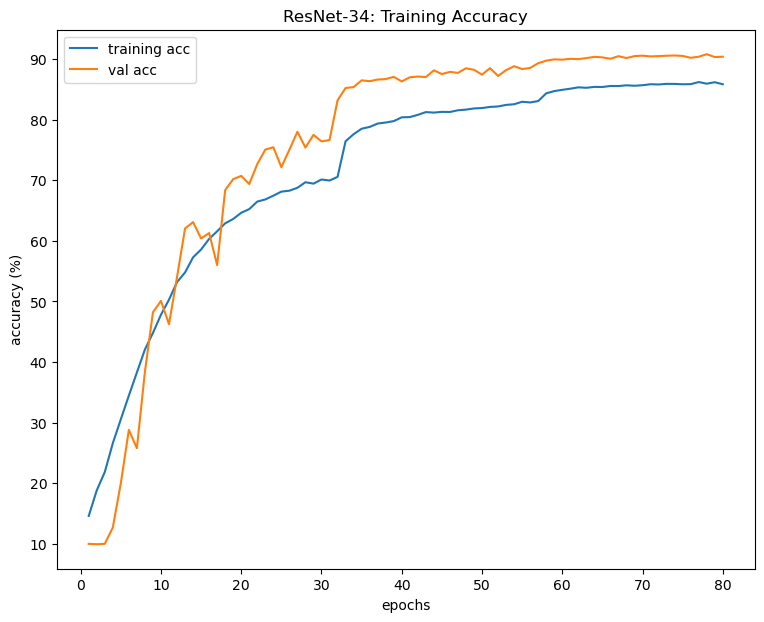

In [27]:
# Visualize ResNet-training-
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['acc'] for k in training_history_lr_scheduler.keys()], label = 'training acc')
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['val_acc'] for k in training_history_lr_scheduler.keys()], label = 'val acc')
plt.title("ResNet-34: Training Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy (%)")
plt.legend(loc = 'best')
plt.show()

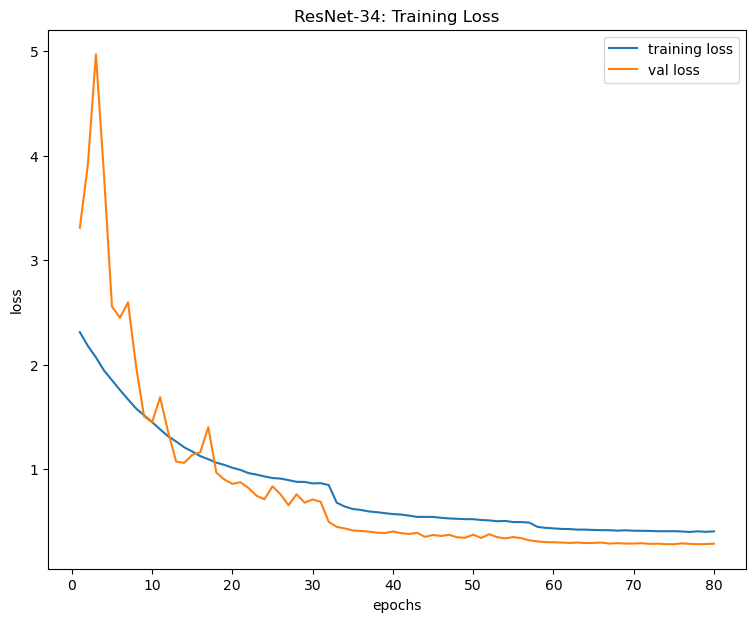

In [28]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['loss'] for k in training_history_lr_scheduler.keys()], label = 'training loss')
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['val_loss'] for k in training_history_lr_scheduler.keys()], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("ResNet-34: Training Loss")
plt.show()

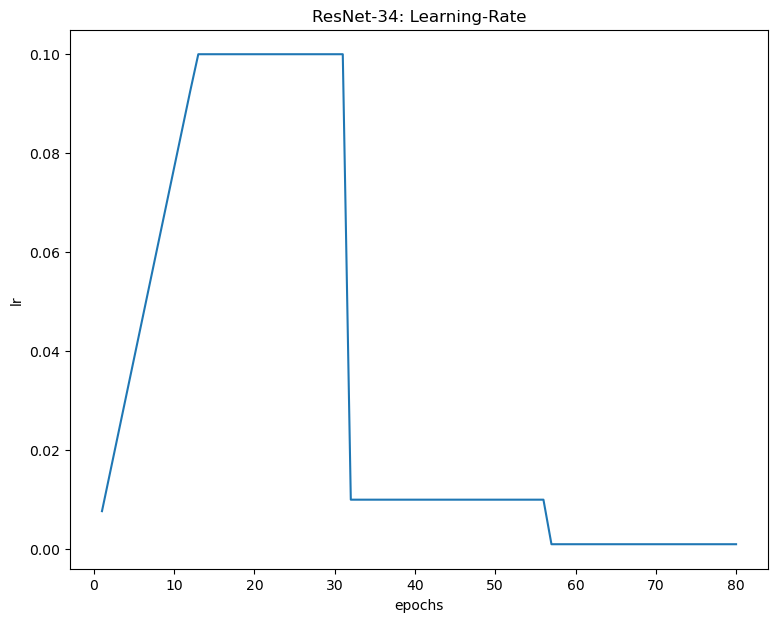

In [29]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['lr'] for k in training_history_lr_scheduler.keys()])
plt.xlabel("epochs")
plt.ylabel("lr")
plt.title("ResNet-34: Learning-Rate")
plt.show()